# Expand backprop analysis

- train multiple models for analysis
- do backprop from final output to all of the intermediate layer outputs (as well as the inputs)
- confirm task orthogonality throughout

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import random

## Train multiple models

In [2]:
# !python train.py

In [3]:
df = pd.read_pickle("results/results.pkl")
len(df)

100

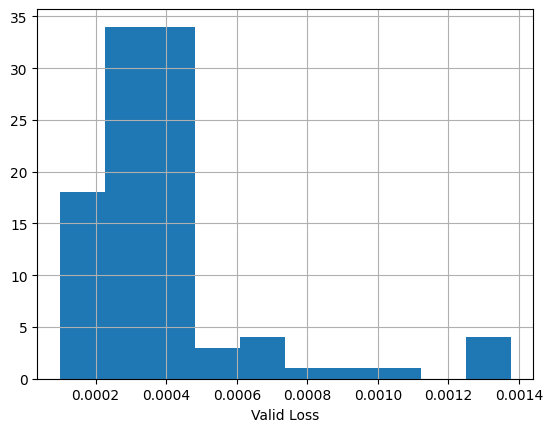

In [4]:
fig, ax = plt.subplots()
df["valid_loss"].hist(ax=ax)
_ = ax.set_xlabel("Valid Loss")

The models look like they've trained well.

## Backprop

In [5]:
from train import generate_data, Net
from physics_mi.utils import set_all_seeds
from physics_mi.analysis import capture_intermediate_outputs

In [6]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx:]
        out = sub_net(linputs)
        return out

The following code is going to:
- iterate through each
    - model
    - layer
    - task
- load the model into the scaffold net
- backpropagate from the task output to the layer in question
- save the gradients

In [7]:
layer_keys = ["input", "layers.0.act", "layers.1.act"]
tasks = ["A", "B"]

rows = []
for i, row in tqdm(df.iterrows(), total=len(df)):  # for each trained model
    set_all_seeds(row["seed"])
    _, _, X_valid, _ = generate_data()
    model = Net()
    model.load_state_dict(row["model"])
    valid_ios = capture_intermediate_outputs(model, X_valid)
    valid_ios = {
        "input": X_valid,
        **valid_ios,
    }  # we'd like to compute the gradients of the inputs too

    scaffold_model = ScaffoldNet()
    scaffold_model.load_state_dict(model.state_dict())

    grads = {}
    for i, lk in enumerate(layer_keys):  # for each intermediate layer
        grads[lk] = {}
        for j, task in enumerate(tasks):  # for each task output
            # generate grads
            linput = valid_ios[lk]
            linput = linput.clone().requires_grad_(True)
            out = scaffold_model(i, linput)
            loss = out[:, j].mean()
            loss.backward()

            # process grads
            grad = linput.grad.clone().detach()
            uq_grads = grad.unique(dim=0)
            uq_grads_norm = uq_grads.norm(dim=1)
            sort_idxs = uq_grads_norm.argsort(descending=True)
            uq_grads, uq_grads_norm = uq_grads[sort_idxs], uq_grads_norm[sort_idxs]

            # store grads
            grads[lk][task] = {}
            grads[lk][task]["comps"] = uq_grads / uq_grads_norm[:, None]
            grads[lk][task]["norms"] = uq_grads_norm

    row["grads"] = grads

    rows.append(row)

df = pd.DataFrame(rows)

  0%|          | 0/100 [00:00<?, ?it/s]

## Analysis

In [8]:
def plot_comp_variances(varA, varB, comp_norms, err_varA=None, err_varB=None):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot the variances for Task A and Task B
    ax1.bar(
        range(len(varA)),
        varA,
        yerr=err_varA,
        width=0.4,
        align="center",
        label="Task A activations",
        alpha=0.5,
    )
    ax1.bar(
        range(len(varB)),
        varB,
        yerr=err_varB,
        width=0.4,
        align="center",
        label="Task B activations",
        alpha=0.5,
    )
    ax1.set_xlabel("Unique Gradient Component")
    ax1.set_ylabel("Variance")
    ax1.legend(loc="upper left")

    # Create a second y-axis for PC importance
    ax2 = ax1.twinx()
    ax2.scatter(
        range(len(comp_norms)),
        comp_norms,
        label="Gradient Component Norm",
        color="r",
        marker="o",
    )
    ax2.set_ylim(0)
    ax2.set_ylabel("Norm")
    ax2.legend(loc="upper right")

    ax1.set_title(
        "Task-wise variance explained in activations by each unique gradient component"
    )

In [9]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs


task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)

sliceA = slice(0, 10000)
sliceB = slice(10000, None)

task_inputs.shape

torch.Size([20000, 4])

In [10]:
row = df.sample().iloc[0]

model = Net()
model.load_state_dict(row["model"])
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios = {
    "input": task_inputs,
    **task_ios,
}  # we'd like to compute the gradients of the inputs too

comp_acts = {}
for lk in layer_keys:
    comp_acts[lk] = {}
    for t, task in enumerate(tasks):
        d = row["grads"][lk][task]
        comps = d["comps"] * d["norms"][:, None]
        comp_acts[lk][task] = torch.einsum(
            "ij,kj->ki", comps, task_ios[lk]
        )  # component activation

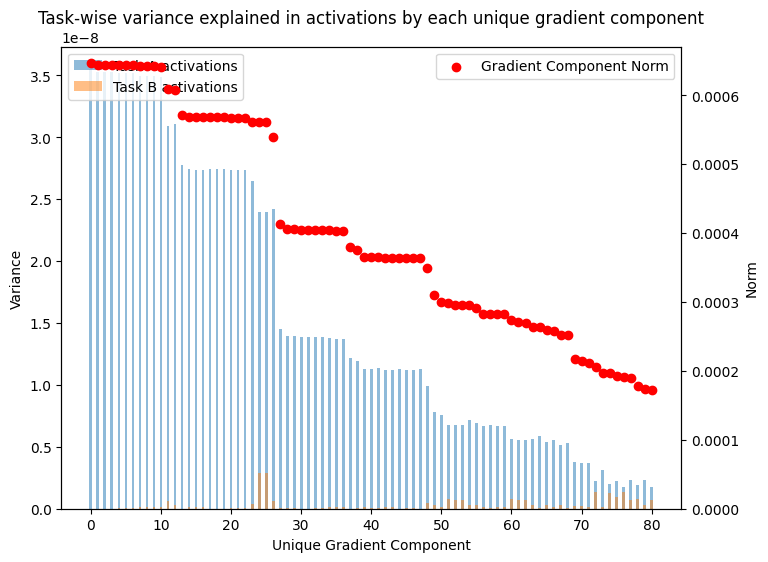

In [23]:
lk = random.choice(layer_keys)
task = random.choice(tasks)

plot_comp_variances(
    comp_acts[lk][task][sliceA].var(dim=0),
    comp_acts[lk][task][sliceB].var(dim=0),
    row["grads"][lk][task]["norms"],
)

Cool so I can make these graphs for an individual model, but I need a way of aggregating my results across different trained examples and extracting statistics. I think for each component I could extract:
- the gradient component norm
- the percentage of the gradient that arises from the principal task - this would be the the monotask fraction multiplied by the gradient norm for each component

I feel like each layer might produce the same result with this measure but hey I'll do it for each layer separately anyway.

## Aggregate analysis

In [69]:
from collections import defaultdict

df["grad_cap"] = None

for i, row in tqdm(df.iterrows(), total=len(df)):
    model = Net()
    model.load_state_dict(row["model"])
    task_ios = capture_intermediate_outputs(model, task_inputs)
    task_ios = {
        "input": task_inputs,
        **task_ios,
    }  # we'd like to compute the gradients of the inputs too

    comp_acts, grad_cap = defaultdict(dict), defaultdict(dict)
    for lk in layer_keys:
        for t, task in enumerate(tasks):
            d = row["grads"][lk][task]
            comps = d["comps"] * d["norms"][:, None]
            comp_acts[lk][task] = torch.einsum(
                "ij,kj->ki", comps, task_ios[lk]
            )  # component activation
            acts = comp_acts[lk][task]
            vars = torch.stack((acts[sliceA].var(dim=0), acts[sliceB].var(dim=0)))
            var_captures = vars.max(0).values / vars.sum(0)
            norms = row["grads"][lk][task]["norms"]
            grad_captures = var_captures * norms
            grad_capture = grad_captures.sum() / norms.sum()
            grad_cap[lk][task] = float(grad_capture)
    df.at[i, "grad_cap"] = grad_cap

  0%|          | 0/100 [00:00<?, ?it/s]

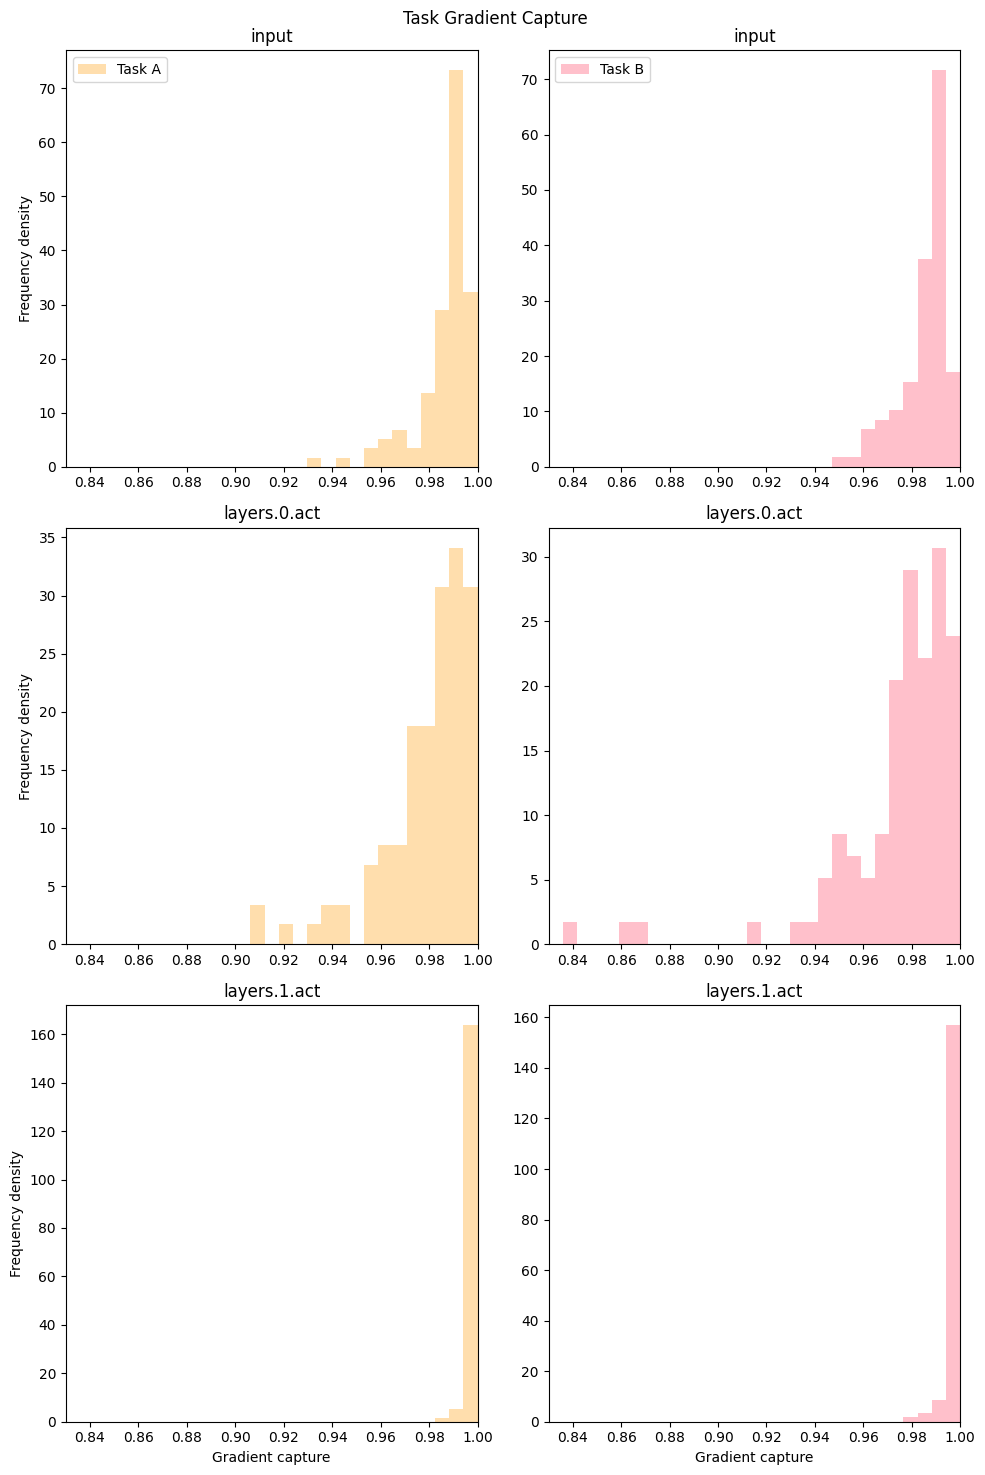

In [109]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

colors = {"A": "navajowhite", "B": "pink"}
bins = np.linspace(0.83, 1.0, 30)

for i, lk in enumerate(layer_keys):
    for j, task in enumerate(tasks):
        ax = axes[i, j]
        col = colors[task]
        ax.hist(
            df["grad_cap"].map(lambda d: d[lk][task]),
            color=col,
            label=f"Task {task}",
            density=True,
            bins=bins,
        )
        ax.set_title(lk)
        ax.set_xlim((0.83, 1.0))

for ax in axes[0]:
    ax.legend()

for ax in axes[-1]:
    ax.set_xlabel("Gradient capture")

for ax in axes[:, 0]:
    ax.set_ylabel("Frequency density")

fig.suptitle(f"Task Gradient Capture")
fig.tight_layout()

for ax in axes[0]:
    ax.legend()

We can view the _task gradient capture_ as the proportion of the entire gradient contributing to the task output in question that is captured by variance in the corresponding task components. It is some measure of how independent each of the tasks is at each layer.

It's interesting how `layer.0.act` is generally less independent than the other layers. It maybe makes sense that the final layer is the most independent as this is what "counts" the most?

Now looking to see whether this measure of independence correlates with loss. I'd weakly hypothesise that higher independence should correlate with lower loss, but I've had issues finding these relationships in the past so let's see: 

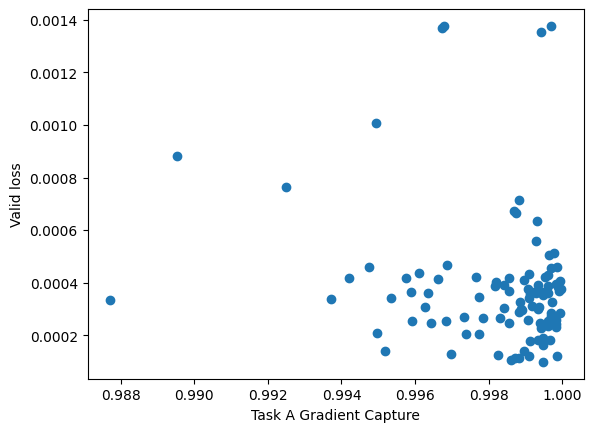

In [119]:
fig, ax = plt.subplots()

ax.scatter(df["grad_cap"].map(lambda d: d[layer_keys[-1]]["A"]), df["valid_loss"])
ax.set_xlabel("Task A Gradient Capture")
_ = ax.set_ylabel("Valid loss")

Ok, not much to see here - there must be other (larger) sources of error.

Now I think I have quite conclusively proved clean task independence throughout the intermediate layers of this network.

Now to see if I can draw nice connection graphs 🤤